## The Oren-Nayar (1994) reflectance model

In this notebook we validate our approximation to the Oren-Nayar scattering model.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [19]:
import matplotlib.pyplot as plt
import numpy as np
np.seterr(invalid="ignore");

Here's a reproduction of Figure 9 in Oren & Nayar (1994):

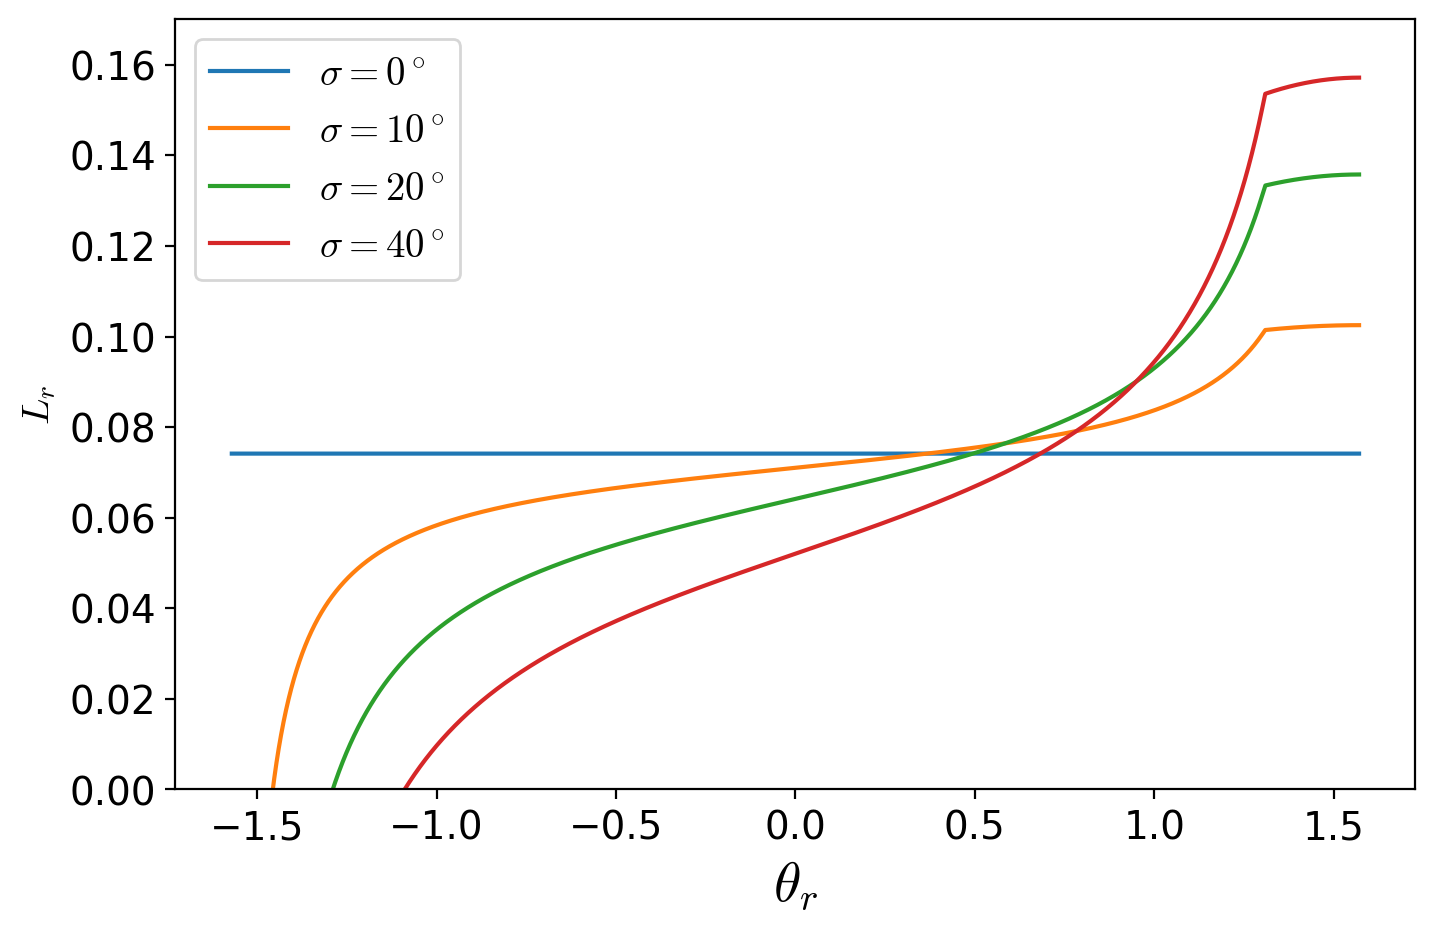

In [10]:
theta_i = 75 * np.pi / 180
fig, ax = plt.subplots(1, figsize=(8, 5))
for sig in np.array([0, 10, 20, 40]) * np.pi / 180:
    sig2 = sig ** 2
    A = 1 - 0.5 * sig2 / (sig2 + 0.33)
    B = 0.45 * sig2 / (sig2 + 0.09)
    theta_r = np.linspace(-90, 90, 10000) * np.pi / 180
    alpha = np.maximum(theta_r, theta_i)
    beta = np.minimum(theta_r, theta_i)
    I = 0.9 / np.pi * np.cos(theta_i) * (A + B * np.sin(alpha) * np.tan(beta))
    plt.plot(theta_r, I, label=r"$\sigma = {:.0f}^\circ$".format(sig * 180 / np.pi))
plt.legend()
plt.xlabel(r"$\theta_r$", fontsize=20)
plt.ylabel(r"$L_r$")
plt.ylim(0, 0.17);

Here's the standard Lambertian reflectance as a function of `b` and `theta` at a point `(x, y)` on the surface, as derived in the paper:

In [12]:
@np.vectorize
def Lambertian(b, theta, x, y):
    """Lambertian intensity at a point on the surface."""
    ct = np.cos(theta)
    st = np.sin(theta)
    bc = np.sqrt(1 - b ** 2)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    ci = -bc * st * x + bc * ct * y - b * z
    return np.maximum(0, ci)

:And here's the Oren-Nayar (1994) reflectance from their Equation (30):

In [13]:
def R(axis=[0, 1, 0], theta=0):
    """Axis-angle rotation matrix in 3D."""
    axis = np.array(axis) / np.sqrt(np.sum(np.array(axis) ** 2))
    cost = np.cos(theta)
    sint = np.sin(theta)
    return np.reshape(
        [
            cost + axis[0] * axis[0] * (1 - cost),
            axis[0] * axis[1] * (1 - cost) - axis[2] * sint,
            axis[0] * axis[2] * (1 - cost) + axis[1] * sint,
            axis[1] * axis[0] * (1 - cost) + axis[2] * sint,
            cost + axis[1] * axis[1] * (1 - cost),
            axis[1] * axis[2] * (1 - cost) - axis[0] * sint,
            axis[2] * axis[0] * (1 - cost) - axis[1] * sint,
            axis[2] * axis[1] * (1 - cost) + axis[0] * sint,
            cost + axis[2] * axis[2] * (1 - cost),
        ],
        [3, 3],
    )

@np.vectorize
def OrenNayarExplicit(b, theta, sig, x, y):
    """Oren-Nayar intensity at a point on the surface (computed explicitly)."""

    # The three vectors in the observer (sky) frame
    bc = np.sqrt(1 - b ** 2)
    s0 = np.array([-bc * np.sin(theta), bc * np.cos(theta), -b])  # source vector
    v0 = np.array([0, 0, 1.0])  # observer vector
    n0 = np.array([x, y, np.sqrt(1 - x ** 2 - y ** 2)])  # normal vector

    # Transform to the surface normal frame
    n = np.array([0, 0, 1.0])  # normal vector

    # Find the rotation matrix that transforms to
    # the normal frame
    axis = np.cross(n0, n)
    costhet = np.dot(n0, n)
    thet = np.arccos(costhet)
    Rn = R(axis, -thet)

    # Check that the sign is right
    # Rn.dot(n0) should be equal to n
    Rnp = R(axis, thet)
    if Rnp.dot(n0)[2] > Rn.dot(n0)[2]:
        Rn = Rnp

    # Rotate s and v
    s = Rn.dot(s0)
    v = Rn.dot(v0)

    # Compute the angles
    theta_r = np.arccos(np.dot(v, n))
    theta_i = np.arccos(np.dot(s, n))
    if theta_i >= np.pi / 2:
        # Unilluminated
        return 0
    phi_r = np.arctan2(v[1], v[0])
    phi_i = np.arctan2(s[1], s[0])
    del_phi = phi_i - phi_r

    # Now compute the intensity
    alpha = max(theta_r, theta_i)
    beta = min(theta_r, theta_i)
    f = max(0, np.cos(del_phi)) * np.sin(alpha) * np.tan(beta)
    sig2 = sig ** 2
    A = 1 - 0.5 * sig2 / (sig2 + 0.33)
    B = 0.45 * sig2 / (sig2 + 0.09)
    S = A + B * f

    return Lambertian(b, theta, x, y) * S

We're going to show that the above model is equivalent to the following, much simpler, equation:

In [14]:
@np.vectorize
def OrenNayar(b, theta, sig, x, y):
    """Oren-Nayar intensity at a point on the surface (simplified)."""
    ct = np.cos(theta)
    st = np.sin(theta)
    bc = np.sqrt(1 - b ** 2)
    z = np.sqrt(1 - x ** 2 - y ** 2)
    ci = -bc * st * x + bc * ct * y - b * z
    f1 = -b / z - ci
    f2 = -b / ci - z
    sig2 = sig ** 2
    A = 1 - 0.5 * sig2 / (sig2 + 0.33)
    B = 0.45 * sig2 / (sig2 + 0.09)
    S = A + B * np.maximum(0, np.minimum(f1, f2))
    return Lambertian(b, theta, x, y) * S

Let's plot the two models for a variety of roughnesses and compare the output images:

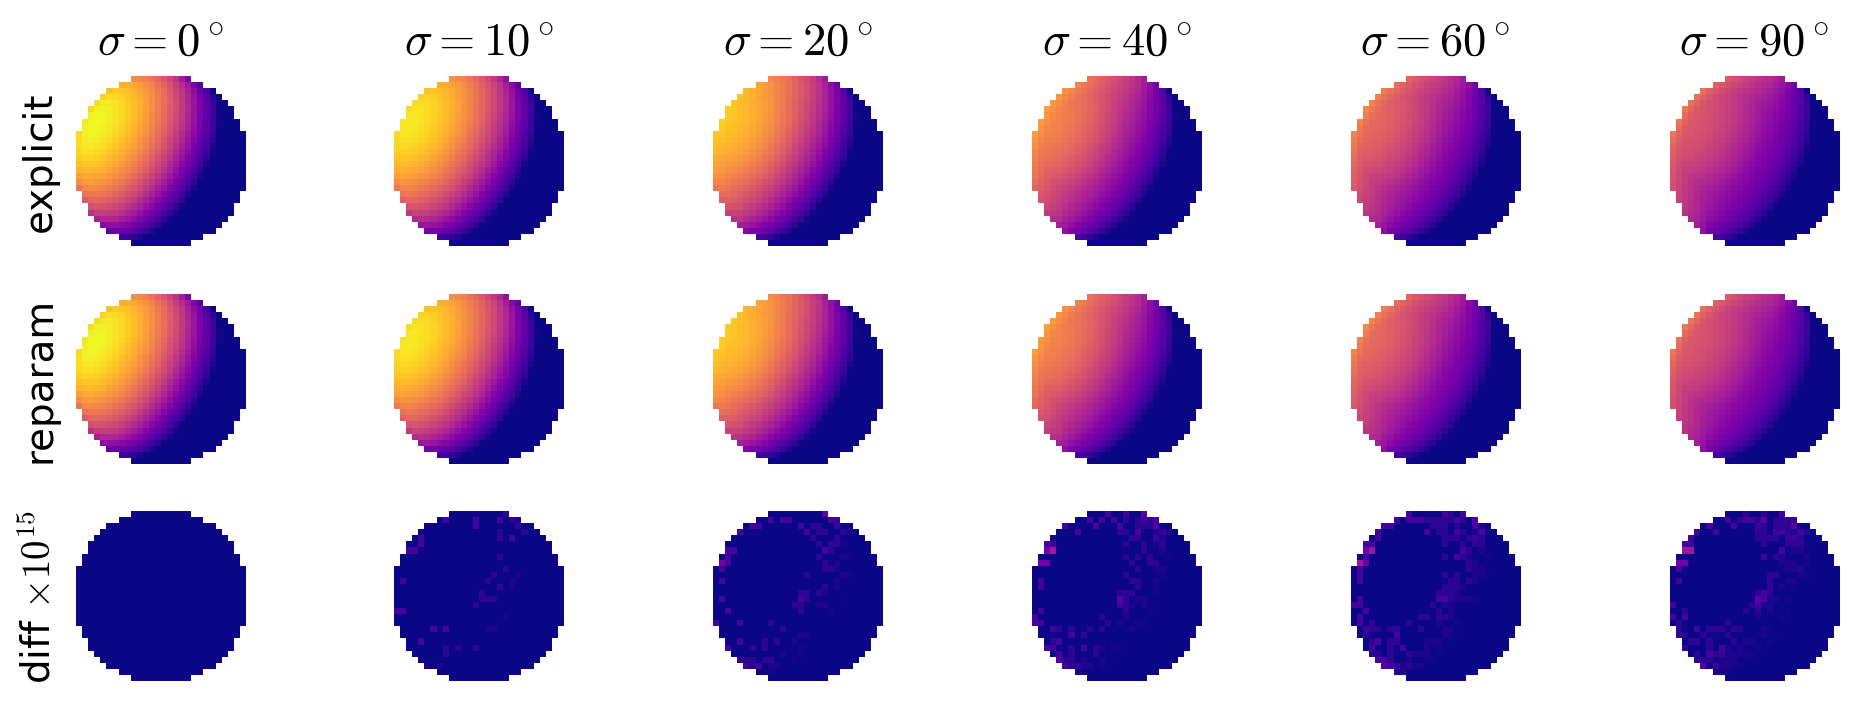

In [32]:
# Params
res = 30
theta = np.pi / 3
b = -0.5
sig = 1.0
deg = 3

# Grid up the surface
grid = np.linspace(-1, 1, res)
x, y = np.meshgrid(grid, grid)

# Plot
fig, ax = plt.subplots(3, 6)
for i, sig in enumerate(np.array([0, 10, 20, 40, 60, 90]) * np.pi / 180):

    # Explicit
    IExplicit = OrenNayarExplicit(b, theta, sig, x, y)
    ax[0, i].imshow(
        IExplicit, origin="lower", extent=(-1, 1, -1, 1), cmap="plasma", vmax=1, vmin=0
    )
    ax[0, i].set(frame_on=False, xticks=[], yticks=[])
    
    # Re-parametrized
    IReparam = OrenNayar(b, theta, sig, x, y)
    ax[1, i].imshow(
        IReparam, origin="lower", extent=(-1, 1, -1, 1), cmap="plasma", vmax=1, vmin=0
    )
    ax[1, i].set(frame_on=False, xticks=[], yticks=[])
    
    # Difference
    ax[2, i].imshow(
        np.abs(IExplicit - IReparam), origin="lower", extent=(-1, 1, -1, 1), cmap="plasma", vmax=1e-15, vmin=0
    )
    ax[2, i].set(frame_on=False, xticks=[], yticks=[])
    
    ax[0, i].set_title(r"$\sigma = {:.0f}^\circ$".format(sig * 180 / np.pi))
    
ax[0, 0].set_ylabel("explicit")
ax[1, 0].set_ylabel("reparam")
ax[2, 0].set_ylabel(r"diff $\times 10^{15}$");